### Libraries

In [2]:
import cv2 as cv
import time
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from functions import * # own functions

### Capture an image
Here we are going to use our laptop camera to take a picture and save it into the folder of images

Taking picture in 2 seconds...
Image saved at images/selfie.jpg


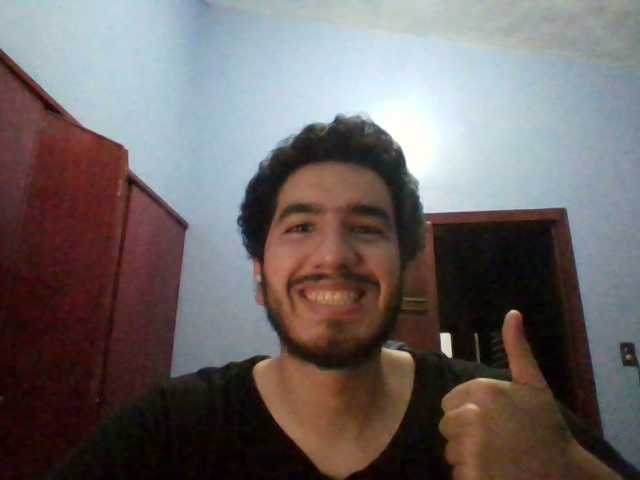

In [10]:
delay = 2
img_path = "images/selfie.jpg"

cap = cv.VideoCapture(0)
print(f"Taking picture in {delay} seconds...")
time.sleep(delay)
ret, frame = cap.read()
if ret:    
    cv.imwrite(img_path, frame)
    print(f"Image saved at {img_path}")
else:
    print("Error: Could not capture an image.")
cap.release()
Image(filename=img_path)

### Change the red and green channels
Here we are going to increase the red channel values and decrease the green channel values

The selfie has 480 x 640 and 3 channels


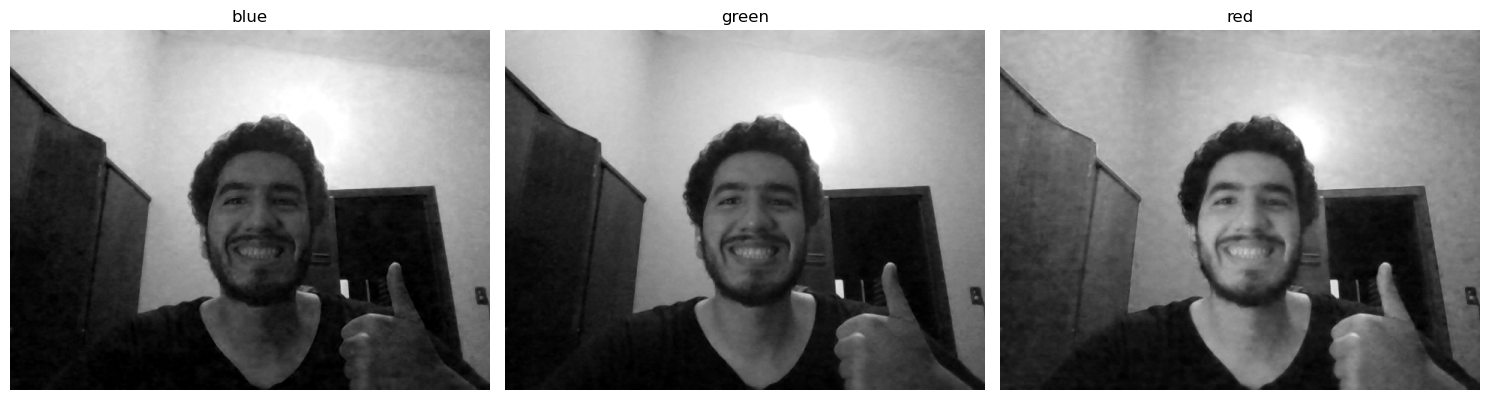

In [11]:
img = cv.imread(img_path)
copy_img = img.copy()
print(f'The selfie has {img.shape[0]} x {img.shape[1]} and {img.shape[2]} channels')

if img.shape[2]:
    channels = ['blue', 'green', 'red']
else:
    print("Check the channels")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i,c in enumerate(channels):
    img_path_c = img_path.replace(".jpg","_"+c+".jpg")
    cv.imwrite(img_path_c,img[:,:,i])
    axes[i].imshow(img[:,:,i], cmap='gray')
    axes[i].set_title(c)

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

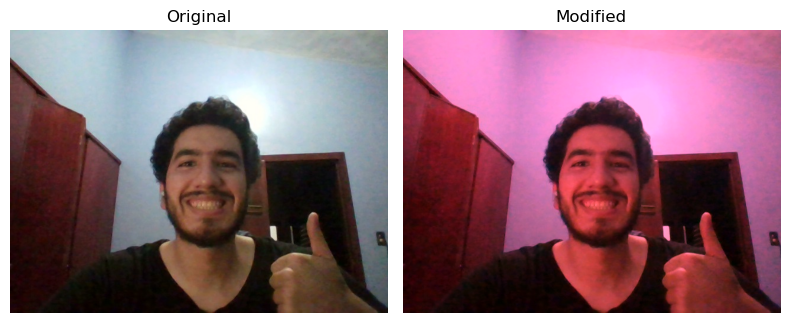

In [12]:
img[:,:,2] = np.minimum(copy_img[:,:,2] * 1.4, 255).astype(np.uint8) # RED
img[:,:,1] = np.maximum(copy_img[:, :, 1] /1.4 , 0).astype(np.uint8) # GREEN

img_path_mod = img_path.replace(".jpg","_modified1.jpg")
cv.imwrite(img_path_mod,img)
plot_img(2,(8,4),["Original", "Modified"],[copy_img, img])

### Convert to Gray Scale

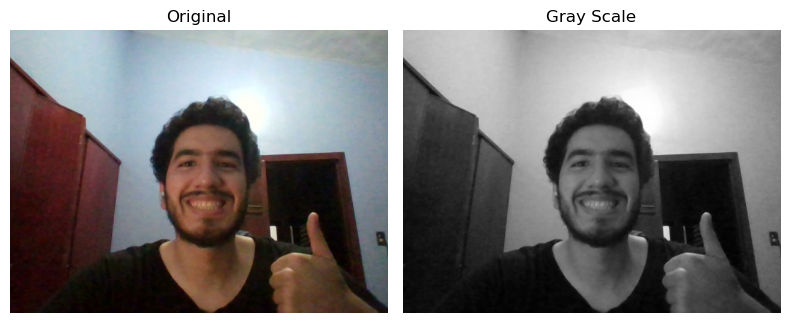

In [15]:
gray = cv.cvtColor(copy_img, cv.COLOR_BGR2GRAY)
img_path_gray = img_path.replace(".jpg","_gray.jpg")
cv.imwrite(img_path_gray,gray)

plot_img(2,(8,4),["Original", "Gray Scale"],[copy_img, gray])

### Invert the Gray Scale (Negative Image)

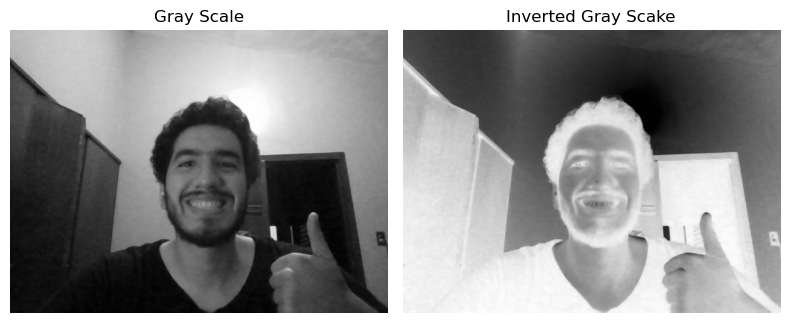

In [16]:
negative_gray = 255 - gray
plot_img(2,(8,4),["Gray Scale", "Inverted Gray Scake"],[gray, negative_gray])

### Change to HSV and display only the H channel
Here we will change the Color-space from BGR to HSV

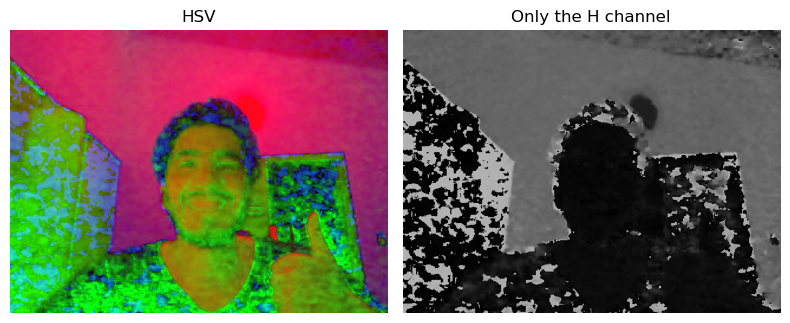

: 

In [18]:
hsv = cv.cvtColor(copy_img, cv.COLOR_BGR2HSV)
plot_img(2,(8,4),["HSV", "Only the H channel"],[hsv, hsv[:,:,0]])

## Using a line pattern
### At what distance you start seeing the Moiré patterns
Here we will capture an image every 0.5 seconds while changing the distance to the camera

In [15]:
interval= 0.5
duration= 10
countdown = 3
frames= list()
pattern_path = "images/pattern.jpg"

cap = cv.VideoCapture(0)
num_frames = int(duration / interval)
for i in range(countdown, 0, -1):
    print(f"Starting in {i}...")
    time.sleep(1)
print("Capturing frames...")

for i in range(num_frames):
        time.sleep(interval)
        ret, frame = cap.read()
        if ret:
            pattern_path_f = pattern_path.replace(".jpg", f'_frame_{i+1}.jpg')
            cv.imwrite(pattern_path_f, frame)
            frames.append(frame)
        else:
            print(f"Error: Could not read frame {i+1}")
    
cap.release() # Release the camera

Starting in 3...
Starting in 2...
Starting in 1...
Capturing frames...


The moiré patterns start at frame 9 and are more evident in frame 12. We manually re-do this experiment with the camara video and measure the distance of the starting point which was 40 cm.

### Find the digital f of your camera (f_Ax)
We will follow some steps from the tutorial https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html but modifying some lines as our chessboard is 8 x 8 (but it had problems identifying it so we searched for a 7 x 7 in our 8 x 8).

In [43]:
num_images = 10 # We need at least 10 to calibrate our camera
delay = 0.5
print(f"Taking picture in {countdown} seconds...")
time.sleep(countdown)
cal_images = list()

cap = cv.VideoCapture(0)
for i in range(num_images):
    ret, frame = cap.read()
    if ret:
        img_path = "images/" + f'calibration_{i+1}.jpg'
        cv.imwrite(img_path, frame)
        cal_images.append(frame)
        print(f"Image {i+1} saved at {img_path}")
    else:
        print(f"Error: Could not capture image {i+1}")
    
    # Wait before taking the next image
    time.sleep(delay)
    
cap.release()

Taking picture in 3 seconds...
Image 1 saved at images/calibration_1.jpg
Image 2 saved at images/calibration_2.jpg
Image 3 saved at images/calibration_3.jpg
Image 4 saved at images/calibration_4.jpg
Image 5 saved at images/calibration_5.jpg
Image 6 saved at images/calibration_6.jpg
Image 7 saved at images/calibration_7.jpg
Image 8 saved at images/calibration_8.jpg
Image 9 saved at images/calibration_9.jpg
Image 10 saved at images/calibration_10.jpg


In [74]:
def get_focal(color, print_c=False):
    # termination criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((7*7,3), np.float32)
    objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    for i in range(num_images):
        fname = "images/" + f'calibration_{i+1}.jpg'
        img = cv.imread(fname)
        if color == 'gray':
            channel = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        elif color == "blue":
            channel = img[:,:,0]
        elif color == "green":
            channel = img[:,:,1]
        else: # red
            channel = img[:,:,2]
    
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(channel, (7,7), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
    
            corners2 = cv.cornerSubPix(channel,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)
    
            # Draw and display the corners
            cv.drawChessboardCorners(img, (7,7), corners2, ret)
            img_path = fname.replace(".jpg", "_draw.jpg")
            cv.imwrite(img_path, img)
    
    titles = [f"Image {i}" for i in range(1, 11)]
    frames = [cv.imread(f'images/calibration_{i}_draw.jpg') for i in range(1, 11)]
    if print_c:
        plot_img(10,(10,5),titles,frames,2)
    
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, channel.shape[::-1], None, None)
    print(f"Focal length in {color} channel, x direction (fx) in pixels: {mtx[0, 0]}")
    print(f"Focal length in {color} channel, y direction (fy) in pixels: {mtx[1, 1]}")


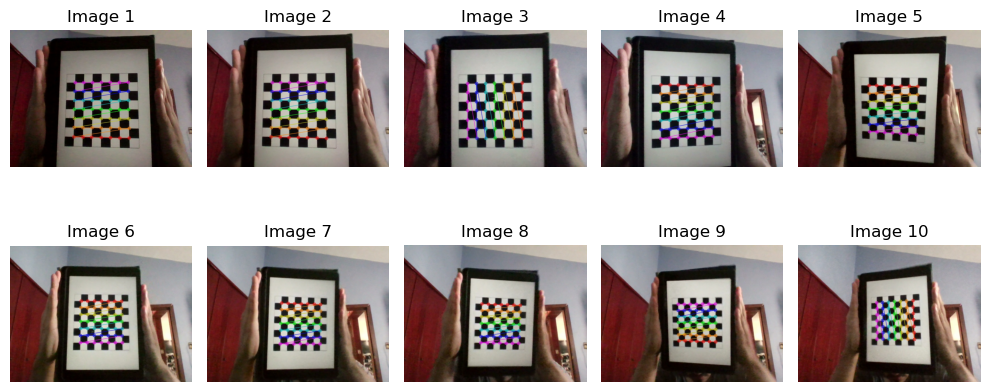

Focal length in gray channel, x direction (fx) in pixels: 518.4429770287403
Focal length in gray channel, y direction (fy) in pixels: 519.3948208478696


In [76]:
get_focal("gray", print_c=True)

### Find the digital f for the Red, Green and Blue Channels

In [80]:
get_focal("blue")
print("")
get_focal("green")
print("")
get_focal("red")

Focal length in blue channel, x direction (fx) in pixels: 518.7476607479122
Focal length in blue channel, y direction (fy) in pixels: 519.6696821998993

Focal length in green channel, x direction (fx) in pixels: 519.7078754184199
Focal length in green channel, y direction (fy) in pixels: 520.6516190679127

Focal length in red channel, x direction (fx) in pixels: 515.9577037373251
Focal length in red channel, y direction (fy) in pixels: 516.946035542895


### Do you see any differences between the Moiré Patterns?
They do intensify with the larger distances

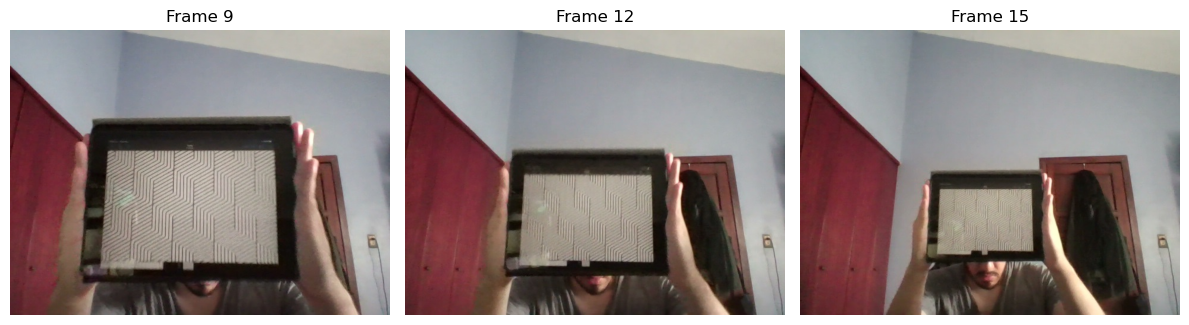

In [85]:
pattern_path = "images/pattern.jpg"
frames = list()
for i in range(num_frames):
    frames.append(cv.imread(pattern_path.replace(".jpg", f'_frame_{i+1}.jpg')))

plot_img(3,(12,6),["Frame 9", "Frame 12", "Frame 15"],[frames[8], frames[11],frames[14]])